# Mean Reversion
### Augmented Dicky Fuller (ADF) test
We will carry out the ADF test on a sample price series of Google stock, from 1st September 2015 to 1st September 2016.

## Questions
### 1. How to choose lag while estimating Hurst Exponent?
### 2. How to choose a time period for pairs trade?

In [2]:
#Import time series library
import statsmodels.tsa.stattools as ts

# Import Datetime and the Pandas DataReader
from datetime import datetime
import pandas_datareader.data as web

#Import plotly
import plotly
import plotly.plotly as py
from plotly.tools import FigureFactory as FF

#Plotly save my credentials
import plotly.tools as tls
tls.set_credentials_file(username='ljinstat', api_key='3okbxgw7mt')

#Import cufflinks and pandas for moving average
import cufflinks as cf
import pandas as pd

In [3]:
# Download the Google Open-High-Low-Close-Volume (OHLCV) data from 1/9/2015 to 1/9/2016 from Yahoo!Finance
start = datetime(2015,9,1)
end = datetime(2016,9,1)
goog = web.DataReader("GOOG", "yahoo", start, end)

In [4]:
# Plot OHLCV data of Google
fig = FF.create_ohlc(goog.Open, goog.High, goog.Low, goog.Close, dates=goog.index)
fig['layout'].update({
    'title': 'OHLC Plot of Google',
    'yaxis': {'title': 'GOOG Stock'}})
py.iplot(fig)

In [5]:
# Output the results of the Augmented Dickey-Fuller test for Google
# with a lag order value of 1
test_result = ts.adfuller(goog['Adj Close'], 1)
test_statistic = test_result[0]
test_pvalue = test_result[1]
test_statistic_level = test_result[4]

In [6]:
print(test_statistic, test_statistic_level)

-2.62969532432 {'1%': -3.4564641849494113, '10%': -2.5728945168648161, '5%': -2.8730327300984171}


The test statistic is larger than any of the critical values at the 1, 5 percent levels, we cannot reject the null hypothesis that $\gamma = 0$ and thus we are unlikely to find out a mean reverting time series.  

### Hurst Exponent
The goal of the Hurst Exponent is to provide us with a scalar value that will help us to identify (within the limits of statistical estimation) whether a series is mean reverting, random walking or trending.


In [7]:
#Import numpy
from numpy import cumsum, log, polyfit, sqrt, std, subtract, var
from numpy.random import randn

In [8]:
def hurst_exponent(ts, num):
	"""Returns the Hurst Exponent of the time series vector ts"""
	# Create the range of lag values
	lags = range(2, num)

	# Calculate the array of the variances of the lagged differences. subtract -> minus two arrays
	variance = [sqrt(std(subtract(ts[lag:], ts[:-lag]))) for lag in lags]

	# Use a linear fit to estimate the Hurst Exponent
	linear_fit = polyfit(log(lags), log(variance), 1)

	# Return the 2 times of Hurst exponent from the linear fit output
	return linear_fit[0]*2.0

In [9]:
# Create a Gometric Brownian Motion, Mean-Reverting and Trending Series
gbm = log(cumsum(randn(100000))+1000)
mr = log(randn(100000)+1000)
tr = log(cumsum(randn(100000)+1)+1000)

In [10]:
#Print all Hurst Exponent lag = 50
print("Hurst(GBM):   %s" % hurst_exponent(gbm, 50))
print("Hurst(MR):    %s" % hurst_exponent(mr, 50))
print("Hurst(TR):    %s" % hurst_exponent(tr, 50))
print("Hurst(GOOG):  %s" % hurst_exponent(log(goog['Adj Close']), 50))

Hurst(GBM):   0.504469781425
Hurst(MR):    -0.000132878782841
Hurst(TR):    0.93850167554
Hurst(GOOG):  0.461031955434


In [11]:
#Print all Hurst Exponent lag = 100
print("Hurst(GBM):   %s" % hurst_exponent(gbm, 100))
print("Hurst(MR):    %s" % hurst_exponent(mr, 100))
print("Hurst(TR):    %s" % hurst_exponent(tr, 100))
print("Hurst(GOOG):  %s" % hurst_exponent(log(goog['Adj Close']), 100))

Hurst(GBM):   0.501698315362
Hurst(MR):    0.000251502608813
Hurst(TR):    0.952711906497
Hurst(GOOG):  0.271027191406


In [12]:
#Print all Hurst Exponent lag = 200
print("Hurst(GBM):   %s" % hurst_exponent(gbm, 200))
print("Hurst(MR):    %s" % hurst_exponent(mr, 200))
print("Hurst(TR):    %s" % hurst_exponent(tr, 200))
print("Hurst(GOOG):  %s" % hurst_exponent(log(goog['Adj Close']), 200))

Hurst(GBM):   0.498657497041
Hurst(MR):    -2.48119340925e-06
Hurst(TR):    0.961146235028
Hurst(GOOG):  0.125340411573


### Cointegrated Augmented Dickey Fuller (CADF) test

It should be noted that it is actually very difficult to find a directly tradable asset that possesses mean-reverting behaviour. For instance, equities broadly behave like GBMs and hence render the mean-reverting trade strategies relatively useless. 

>The simplest form of mean-reverting trade strategies is the classic "pairs trade", which usually involves a dollar-neutral long-short pair of equities. The theory goes that two companies in the same sector are likely to be exposed to similar market factors, which affect their businesses. Occasionally their relative stock prices will diverge due to certain events, but will revert to the long-running mean.

In order to comfirm whether the series is mean reversing, we consider ADF test and Hurst Exponent. However, neither of them can provide $\beta$ which is the relationship between two stocks. Thus, CADF can tell us whether the linear relationship is stationary.

In [13]:
#Import modules
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import pprint

from pandas.stats.api import ols

In [14]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 16, 9

### Pairs trade plot

In [15]:
#Price plot
def plot_price(df, ts1, ts2, time1, time2):
    """Plot two stock prices in one figure
       df : dataframe
       ts1 and ts2 : names of stocks, string
    """
    months = mdates.MonthLocator()  # every month
    
    fig, ax = plt.subplots()
    ax.plot(df.index, df[ts1], label=ts1)
    ax.plot(df.index, df[ts2], label=ts2)
    #ax.xaxis.set_major_locator(months)
    #ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    ax.set_xlim(time1, time2)
    ax.grid(True)
    #fig.autofmt_xdate()

    plt.xlabel('Month/Year')
    plt.ylabel('Price ($)')
    plt.title('%s and %s Daily Prices' % (ts1, ts2))
    plt.legend()
    plt.show()

### Pairs trade scatter plot --- to see linear combination

In [16]:
def plot_scatter_series(df, ts1, ts2):
    plt.xlabel('%s Price ($)' % ts1)
    plt.ylabel('%s Price ($)' % ts2)
    plt.title('%s and %s Price Scatterplot' % (ts1, ts2))
    plt.scatter(df[ts1], df[ts2])
    plt.show()

### Pairs trade residual plot

In [17]:
def plot_residuals(df, time1, time2):
    months = mdates.MonthLocator()  # every month
    fig, ax = plt.subplots()
    ax.plot(df.index, df["res"], label="Residuals")
    #ax.xaxis.set_major_locator(months)
    #ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    ax.set_xlim(time1, time2)
    ax.grid(True)
    fig.autofmt_xdate()

    plt.xlabel('Month/Year')
    plt.ylabel('Price ($)')
    plt.title('Residual Plot')
    plt.legend()

    plt.plot(df["res"])
    plt.show()

### Linear combination and implement of CADF test

We consider two energy sector equities Approach Resources Inc given by the ticker AREX and Whiting Petroleum Corp given by the ticker WLL. Both are exposed to similar market conditions and thus will likely have a stationary pairs relationship. 

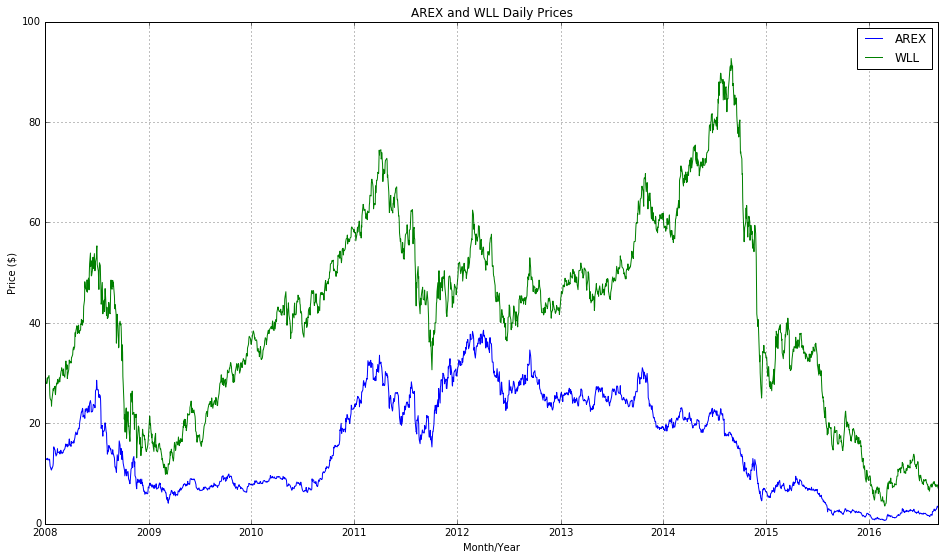

In [18]:
start = datetime(2008, 1, 1)
end = datetime(2016, 9, 1)

arex = web.DataReader("AREX", "yahoo", start, end)
wll = web.DataReader("WLL", "yahoo", start, end)

df = pd.DataFrame(index=arex.index)
df["AREX"] = arex["Adj Close"]
df["WLL"] = wll["Adj Close"]

#Plot the two time series
plot_price(df, "AREX", "WLL", start, end)

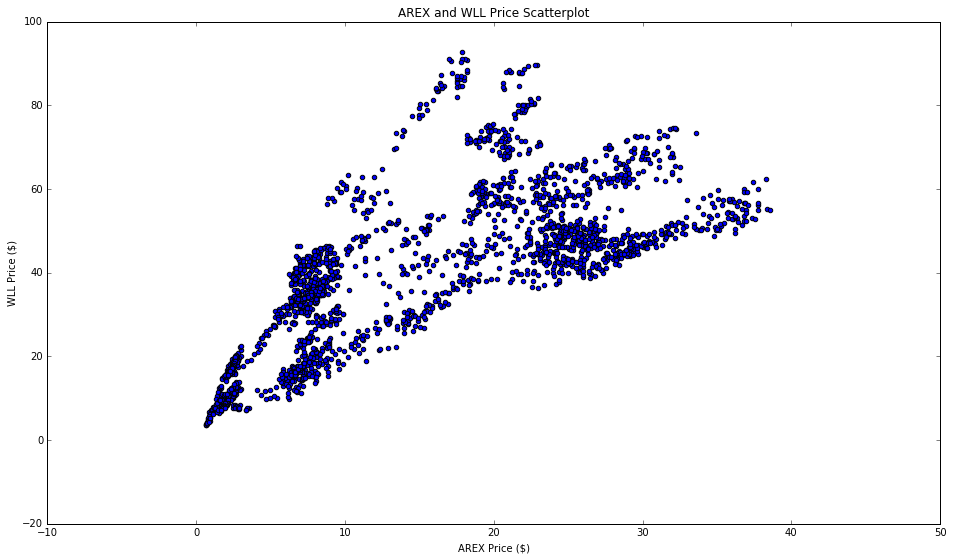

In [19]:
# Display a scatter plot of the two time series
plot_scatter_series(df, "AREX", "WLL")

1.40169848759


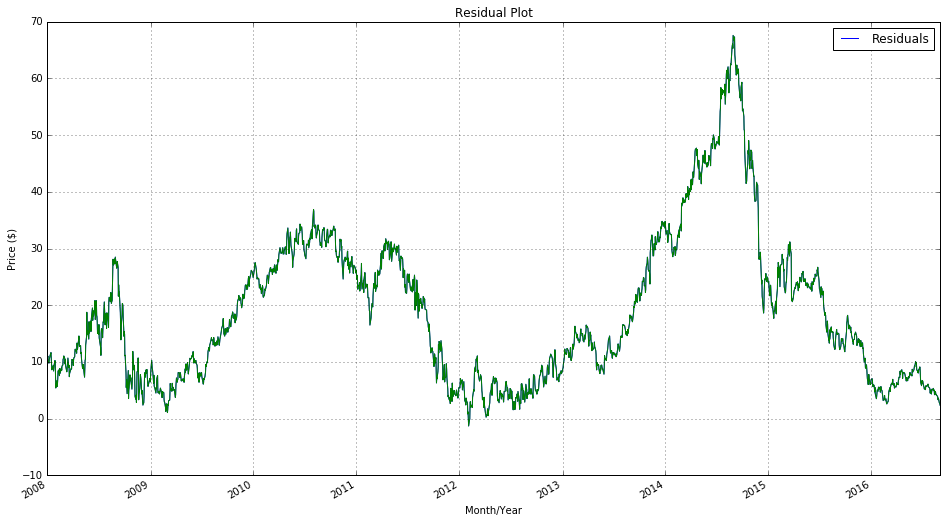

In [20]:
#Calculate optimal hedge ratio "beta" OLS : Ordinary Least Squares 
res = ols(y=df['WLL'], x=df["AREX"])
beta_hr = res.beta.x

print(beta_hr)

# Calculate the residuals of the linear combination
df["res"] = df["WLL"] - beta_hr*df["AREX"]

# Plot the residuals
plot_residuals(df, start, end)

In [21]:
# Calculate and output the CADF test on the residuals
cadf = ts.adfuller(df["res"])

In [22]:
# Output the results of the Augmented Dickey-Fuller test for Google
# with a lag order value of 1
cadf_statistic = cadf[0]
cadf_pvalue = cadf[1]
cadf_statistic_level = cadf[4]

In [23]:
print(cadf_statistic, cadf_statistic_level)

-1.63840160752 {'1%': -3.4333684674663467, '10%': -2.5674798640234444, '5%': -2.8628734534635902}


From 2008 to 2016, it can be seen that the calculated test statistic of -1.63 is bigger than the 5% critical value of -2.86, which means that we cannot reject the null hypothesis that there isn't a cointegrating relationship at the 5% level. Hence we can conclude, with a reasonable degree of certainty, that AREX and WLL do not possess a cointegrating relationship for the time period sample considered.

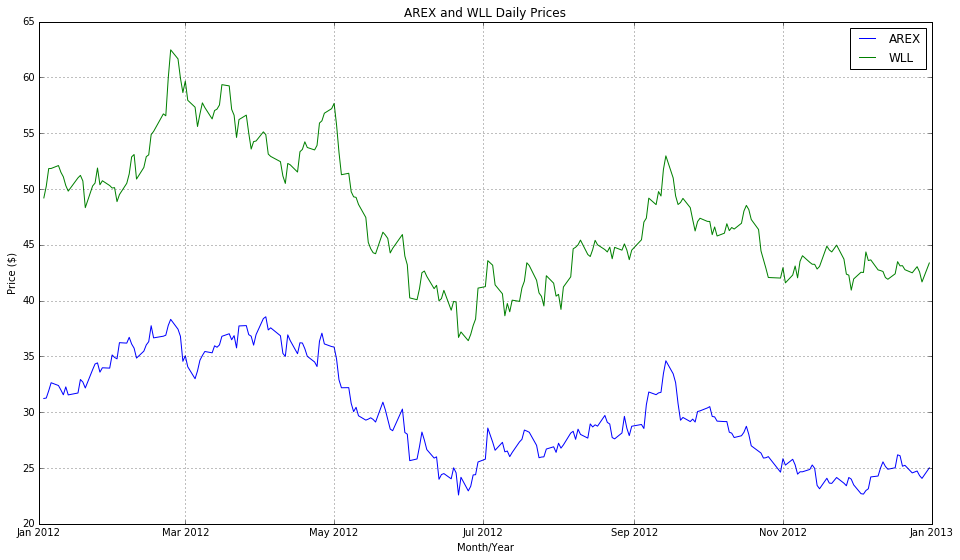

In [36]:
start_short = datetime(2012, 1, 1)
end_short = datetime(2013, 1, 1)

arex_short = web.DataReader("AREX", "yahoo", start_short, end_short)
wll_short = web.DataReader("WLL", "yahoo", start_short, end_short)

df_short = pd.DataFrame(index=arex_short.index)
df_short["AREX"] = arex_short["Adj Close"]
df_short["WLL"] = wll_short["Adj Close"]

#Plot the two time series
plot_price(df_short, "AREX", "WLL", start_short, end_short)

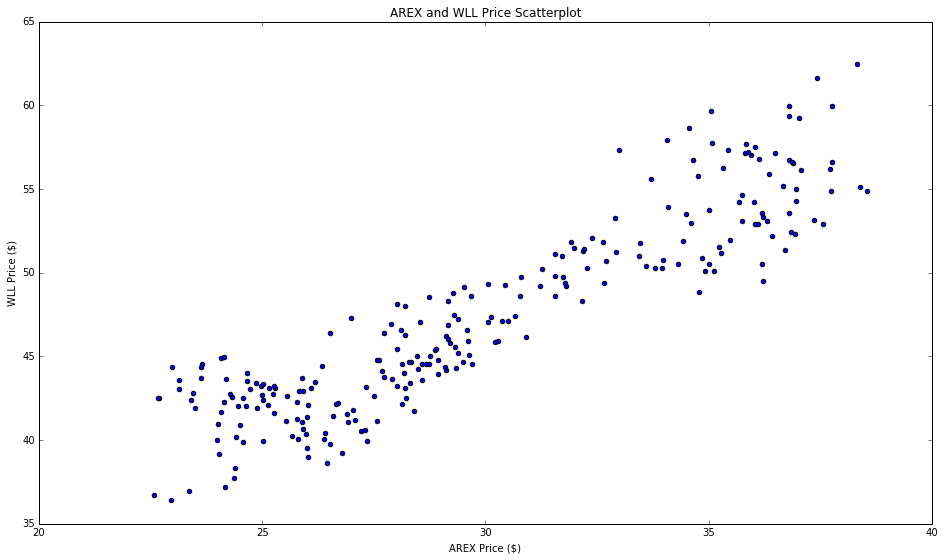

In [37]:
# Display a scatter plot of the two time series
plot_scatter_series(df_short, "AREX", "WLL")

1.16907173401


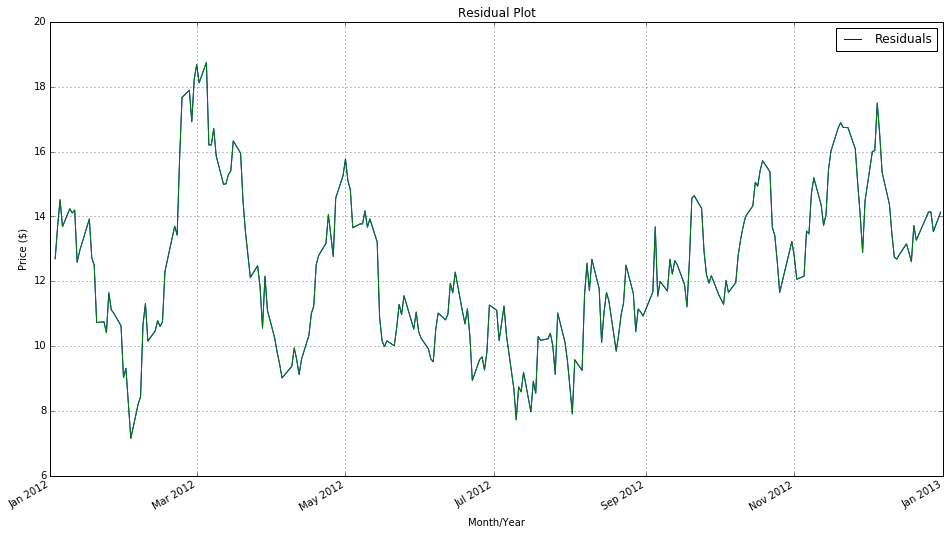

In [38]:
#Calculate optimal hedge ratio "beta" OLS : Ordinary Least Squares 
res_short = ols(y=df_short['WLL'], x=df_short["AREX"])
beta_hr_short = res_short.beta.x

print(beta_hr_short)

# Calculate the residuals of the linear combination
df_short["res"] = df_short["WLL"] - beta_hr_short*df["AREX"]

# Plot the residuals
plot_residuals(df_short, start_short, end_short)

In [39]:
# Calculate and output the CADF test on the residuals
cadf_short = ts.adfuller(df_short["res"])

In [40]:
# Output the results of the Augmented Dickey-Fuller test for Google
# with a lag order value of 1
cadf_statistic_short = cadf_short[0]
cadf_pvalue_short = cadf_short[1]
cadf_statistic_level_short = cadf_short[4]

In [41]:
print(cadf_statistic_short, cadf_statistic_level_short)

-2.96070146369 {'1%': -3.4568881317725864, '10%': -2.5729936189738876, '5%': -2.8732185133016057}


From 2011 to 2012, it can be seen that the calculated test statistic of -2.96 is smaller than the 5% critical value of -2.57, which means that we can reject the null hypothesis that there isn't a cointegrating relationship at the 5% level. Hence we can conclude, with a reasonable degree of certainty, that AREX and WLL possess a cointegrating relationship for the time period sample considered.

I also tested two periods, from 1/1/2011 to 1/1/2013 and from 1/1/2011 to 1/9/2012, results show that AREX and WLL do not possess a cointegrating relationship. So choosing a right period is essential! Although a sub-period is has stationary pairs relationship, for the entire period, it is not.

## Intraday mean reversion pairs strategy between SPY and IWM

>SPY and IWM are two Exchange Traded Funds(ETFs), which are traded on the New York Stock Exchange (NYSE) and represent the US stock market indices, the S&P500 and the Russell 2000, respectively.

The strategy broadly creates a "spread" between the pair of ETFs by longing one and shorting an amount of the other. The ratio of long to short can be defined in many ways such as utilising statistical cointegrating time series techniques.

### The strategy

1. Data : 1-minute bars of SPY and IWM are obtained from April 2007 through to February 2014.

2. Processing : The data are correctly aligned and missing bars are mutually discarded.

3. Spread : The hedge ratio between the two ETFs is calculated by taking a rolling linear regression. 

4. Z-Score : The standard score of the spread is calculated in the usual manner. This means subtracting the (sample) mean of the spread and dividing by the (sample) standard deviation of the spread. There is a lookahead bias in the calculation.

5. Trades : Long signals are generated when the negative z-score drops below a pre-determined (or post-optimised) threshold, while short signals are the converse of this. Exit signals are generated when the absolute z-score drops below an additional threshold. For this strategy I have (somewhat arbitrarily) picked an absolute entry threshold of |z|=2 and an exit threshold of |z|=1.